In [6]:
import json
import bz2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# match your other EDA notebooks
DATA_DIR = Path("../data/raw")
EVENT_DIR = DATA_DIR / "event_data" / "May 1, 2025"
TRACKING_DIR = DATA_DIR / "tracking_data"

print("EVENT_DIR exists:", EVENT_DIR.exists(), EVENT_DIR)
print("TRACKING_DIR exists:", TRACKING_DIR.exists(), TRACKING_DIR)

# quick sanity: what files are available?
event_files = sorted(EVENT_DIR.glob("*.json"))
tracking_files = sorted(TRACKING_DIR.glob("*.jsonl.bz2"))

print("num event files:", len(event_files))
print("sample event files:", [p.name for p in event_files[:3]])
print("num tracking files:", len(tracking_files))
print("sample tracking files:", [p.name for p in tracking_files[:3]])

EVENT_DIR exists: True ../data/raw/event_data/May 1, 2025
TRACKING_DIR exists: True ../data/raw/tracking_data
num event files: 64
sample event files: ['10502.json', '10503.json', '10504.json']
num tracking files: 5
sample tracking files: ['3812.jsonl.bz2', '3813.jsonl.bz2', '3814.jsonl.bz2']


In [7]:
match_id = "3812"

event_path = EVENT_DIR / f"{match_id}.json"
tracking_path = TRACKING_DIR / f"{match_id}.jsonl.bz2"

print("Loading match:", match_id)
print("Event path:", event_path)
print("Tracking path:", tracking_path)

Loading match: 3812
Event path: ../data/raw/event_data/May 1, 2025/3812.json
Tracking path: ../data/raw/tracking_data/3812.jsonl.bz2


In [8]:
print(type(event_data))
print("Number of events:", len(event_data))
print("Keys of first event:")
print(event_data[0].keys())

<class 'list'>
Number of events: 2010
Keys of first event:
dict_keys(['gameId', 'gameEventId', 'possessionEventId', 'startTime', 'endTime', 'duration', 'eventTime', 'sequence', 'gameEvents', 'initialTouch', 'possessionEvents', 'fouls', 'grades', 'stadiumMetadata', 'homePlayers', 'awayPlayers', 'ball'])


In [10]:
match_id = "3812"
event_path = EVENT_DIR / f"{match_id}.json"

with open(event_path, "r") as f:
    raw = json.load(f)

df = pd.json_normalize(raw)

print("rows:", df.shape[0], "cols:", df.shape[1])
print("\nColumns containing 'possessionEvents' or 'gameEvents':")
cols = [c for c in df.columns if "possessionEvents" in c or "gameEvents" in c]
print(cols[:40])
print("... total:", len(cols))

print("\nTop possession action types:")
print(df["possessionEvents.possessionEventType"].value_counts().head(15))

rows: 2010 cols: 210

Columns containing 'possessionEvents' or 'gameEvents':
['gameEvents.gameEventType', 'gameEvents.initialNonEvent', 'gameEvents.startGameClock', 'gameEvents.startFormattedGameClock', 'gameEvents.period', 'gameEvents.videoMissing', 'gameEvents.teamId', 'gameEvents.teamName', 'gameEvents.homeTeam', 'gameEvents.playerId', 'gameEvents.playerName', 'gameEvents.touches', 'gameEvents.touchesInBox', 'gameEvents.setpieceType', 'gameEvents.earlyDistribution', 'gameEvents.videoUrl', 'gameEvents.endType', 'gameEvents.outType', 'gameEvents.subType', 'gameEvents.playerOffId', 'gameEvents.playerOffName', 'gameEvents.playerOffType', 'gameEvents.playerOnId', 'gameEvents.playerOnName', 'possessionEvents.possessionEventType', 'possessionEvents.nonEvent', 'possessionEvents.gameClock', 'possessionEvents.formattedGameClock', 'possessionEvents.eventVideoUrl', 'possessionEvents.ballHeightType', 'possessionEvents.bodyType', 'possessionEvents.highPointType', 'possessionEvents.passerPlayerId'

In [11]:
passes = df[df["possessionEvents.possessionEventType"] == "PA"].copy()

print("Number of passes:", len(passes))

print("\nPass outcome breakdown:")
print(passes["possessionEvents.passOutcomeType"].value_counts())

print("\nAvailable pass-related columns:")
pass_cols = [c for c in passes.columns if "pass" in c.lower()]
print(pass_cols)

Number of passes: 891

Pass outcome breakdown:
possessionEvents.passOutcomeType
C    719
D    134
O     16
S     12
B     10
Name: count, dtype: int64

Available pass-related columns:
['possessionEvents.passerPlayerId', 'possessionEvents.passerPlayerName', 'possessionEvents.passType', 'possessionEvents.passOutcomeType', 'grades.passerGrade']


In [12]:
location_cols = [c for c in df.columns if any(x in c.lower() for x in ["x", "y", "location", "coord"])]
print(location_cols)

['homePlayers', 'awayPlayers', 'gameEvents.gameEventType', 'gameEvents.playerId', 'gameEvents.playerName', 'gameEvents.touchesInBox', 'gameEvents.setpieceType', 'gameEvents.earlyDistribution', 'gameEvents.endType', 'gameEvents.outType', 'gameEvents.subType', 'gameEvents.playerOffId', 'gameEvents.playerOffName', 'gameEvents.playerOffType', 'gameEvents.playerOnId', 'gameEvents.playerOnName', 'initialTouch.initialBodyType', 'initialTouch.initialHeightType', 'initialTouch.facingType', 'initialTouch.initialTouchType', 'initialTouch.initialPressureType', 'initialTouch.initialPressurePlayerId', 'initialTouch.initialPressurePlayerName', 'possessionEvents.possessionEventType', 'possessionEvents.ballHeightType', 'possessionEvents.bodyType', 'possessionEvents.highPointType', 'possessionEvents.passerPlayerId', 'possessionEvents.passerPlayerName', 'possessionEvents.passType', 'possessionEvents.passOutcomeType', 'possessionEvents.crosserPlayerId', 'possessionEvents.crosserPlayerName', 'possessionEve

In [13]:
passes[[
    "possessionEvents.gameClock",
    "possessionEvents.formattedGameClock",
    "startTime",
    "eventTime"
]].head(10)

,possessionEvents.gameClock,possessionEvents.formattedGameClock,startTime,eventTime
0,0.0,00:00,141.008,141.008
2,3.0,00:03,142.075,144.645
4,6.0,00:06,146.880,147.781
5,8.0,00:08,149.082,149.082
7,11.0,00:11,150.317,152.653
9,14.0,00:14,154.254,155.656
11,20.0,00:20,157.191,161.728
13,24.0,00:24,163.063,165.966
15,27.0,00:27,167.434,168.135
16,28.0,00:28,169.436,169.436


## Pass Event Time Structure (Match 3812)

After isolating possession events where `possessionEvents.possessionEventType == "PA"`,
we inspected the time-related fields.

### Relevant Columns

- `possessionEvents.gameClock`
    - Appears to represent seconds elapsed in the current half.
    - Example: 0.0, 3.0, 6.0, 8.0, 11.0...

- `possessionEvents.formattedGameClock`
    - Human-readable format of gameClock (MM:SS).
    - Example: 00:00, 00:03, 00:06...

- `startTime`
    - Floating-point timestamp (~140–170 range in sample).
    - Likely absolute tracking clock time.

- `eventTime`
    - Floating-point timestamp.
    - Often slightly later than startTime.
    - May represent event completion time.

### Initial Observations

- `gameClock` increases in whole seconds.
- `startTime` and `eventTime` appear to be high-resolution timestamps.
- These timestamps will likely be used to align pass events with tracking frames.

### Implication for Pass Probability

To compute pass probability:
- We must align pass `startTime` (or `eventTime`) to the closest tracking frame timestamp.
- Tracking data likely contains higher-frequency timestamps (e.g., 10 fps or 25 fps).

In [15]:
# pick one pass
one_pass = passes.iloc[0]

pass_clock = one_pass["possessionEvents.gameClock"]
pass_period = one_pass["gameEvents.period"]

print("Pass clock:", pass_clock)
print("Pass period:", pass_period)

# find closest tracking frame
closest_frame = None
min_diff = 1e9

with bz2.open(tracking_path, "rt") as f:
    for line in f:
        frame = json.loads(line)
        
        if frame["period"] != pass_period:
            continue
        
        diff = abs(frame["periodGameClockTime"] - pass_clock)
        
        if diff < min_diff:
            min_diff = diff
            closest_frame = frame
        
        # small optimization: break if diff is basically zero
        if diff < 0.01:
            break

print("Closest time diff:", min_diff)
print("Matched tracking clock:", closest_frame["periodGameClockTime"])

Pass clock: 0.0
Pass period: 1
Closest time diff: 0.0
Matched tracking clock: 0.0


In [ ]:
# Ball position
ball = closest_frame["balls"]
print("Ball raw structure:", ball)

# Home players
home_players = closest_frame["homePlayers"]
away_players = closest_frame["awayPlayers"]

print("\nNumber of home players:", len(home_players))
print("Number of away players:", len(away_players))

print("\nExample home player dict:") #speed is given to us YESSS
print(home_players[0])

Ball raw structure: [{'visibility': 'VISIBLE', 'x': -0.97, 'y': 0.29, 'z': 0.0}]

Number of home players: 11
Number of away players: 11

Example home player dict:
{'jerseyNum': '21', 'confidence': 'HIGH', 'visibility': 'VISIBLE', 'x': 13.975, 'y': 19.244, 'speed': 0.179}


In [17]:
# Get passer ID from event
passer_id = one_pass["possessionEvents.passerPlayerId"]
print("Passer ID:", passer_id)

# Determine if passer is home or away
home_ids = [p.get("playerId") for p in home_players if "playerId" in p]
away_ids = [p.get("playerId") for p in away_players if "playerId" in p]

print("Home IDs sample:", home_ids[:5])
print("Away IDs sample:", away_ids[:5])

Passer ID: 3315.0
Home IDs sample: []
Away IDs sample: []


In [18]:
print(home_players[0].keys())

dict_keys(['jerseyNum', 'confidence', 'visibility', 'x', 'y', 'speed'])


In [20]:
# Look at first raw event container to inspect player metadata
raw_first = raw[0]

print("Keys in event container:")
print(raw_first.keys())

print("\nInspect homePlayers metadata:")
print(raw_first["homePlayers"][0])

print("\nInspect awayPlayers metadata:")
print(raw_first["awayPlayers"][0])

Keys in event container:
dict_keys(['gameId', 'gameEventId', 'possessionEventId', 'startTime', 'endTime', 'duration', 'eventTime', 'sequence', 'gameEvents', 'initialTouch', 'possessionEvents', 'fouls', 'grades', 'stadiumMetadata', 'homePlayers', 'awayPlayers', 'ball'])

Inspect homePlayers metadata:
{'jerseyNum': 21, 'confidence': 'HIGH', 'visibility': 'VISIBLE', 'x': 13.975, 'y': 19.244, 'speed': 0.179, 'playerId': 13228}

Inspect awayPlayers metadata:
{'jerseyNum': 8, 'confidence': 'HIGH', 'visibility': 'VISIBLE', 'x': 0.444, 'y': -9.613, 'speed': 0.277, 'playerId': 11094}


In [21]:
# Build mapping from event metadata (using first container)
home_meta = raw_first["homePlayers"]
away_meta = raw_first["awayPlayers"]

id_to_jersey = {}

for p in home_meta:
    id_to_jersey[p["playerId"]] = p["jerseyNum"]

for p in away_meta:
    id_to_jersey[p["playerId"]] = p["jerseyNum"]

print("Total players in mapping:", len(id_to_jersey))
print("Example mapping entries:", list(id_to_jersey.items())[:5])

Total players in mapping: 22
Example mapping entries: [(13228, 21), (13901, 4), (2059, 16), (214, 6), (3848, 22)]


In [22]:
passer_jersey = id_to_jersey.get(int(passer_id))
print("Passer jersey number:", passer_jersey)

Passer jersey number: 18


Mapped jersey numbers from event data to player id in tracking data


In [23]:
def find_by_jersey(players_list, jersey_num):
    for p in players_list:
        if int(p.get("jerseyNum")) == int(jersey_num):
            return p
    return None

passer_track = find_by_jersey(home_players, passer_jersey)
if passer_track is None:
    passer_track = find_by_jersey(away_players, passer_jersey)

print("Passer tracking dict:", passer_track)

passer_xy = (passer_track["x"], passer_track["y"])
print("Passer (x, y):", passer_xy)
print("Passer speed:", passer_track.get("speed"))

Passer tracking dict: {'jerseyNum': '18', 'confidence': 'HIGH', 'visibility': 'VISIBLE', 'x': 0.398, 'y': -20.006, 'speed': 0.098}
Passer (x, y): (0.398, -20.006)
Passer speed: 0.098


In [24]:
receiver_id = one_pass["possessionEvents.receiverPlayerId"]
print("Receiver ID:", receiver_id)

receiver_jersey = id_to_jersey.get(int(receiver_id)) if pd.notna(receiver_id) else None
print("Receiver jersey:", receiver_jersey)

receiver_track = None
if receiver_jersey is not None:
    receiver_track = find_by_jersey(home_players, receiver_jersey)
    if receiver_track is None:
        receiver_track = find_by_jersey(away_players, receiver_jersey)

print("Receiver tracking dict:", receiver_track)

if receiver_track is not None:
    receiver_xy = (receiver_track["x"], receiver_track["y"])
    print("Receiver (x, y):", receiver_xy)
    print("Receiver speed:", receiver_track.get("speed"))

Receiver ID: 1522.0
Receiver jersey: 21
Receiver tracking dict: {'jerseyNum': '21', 'confidence': 'HIGH', 'visibility': 'VISIBLE', 'x': 13.975, 'y': 19.244, 'speed': 0.179}
Receiver (x, y): (13.975, 19.244)
Receiver speed: 0.179


In [25]:
import math

px, py = passer_xy
rx, ry = receiver_xy

# 1) pass length
pass_len = math.dist((px, py), (rx, ry))

# determine passer team (which list contained passer)
passer_team = "home" if find_by_jersey(home_players, passer_jersey) is not None else "away"
defenders = away_players if passer_team == "home" else home_players

# helper: distance point -> segment
def point_to_segment_dist(ax, ay, bx, by, px, py):
    # segment AB, point P
    ABx, ABy = (bx-ax), (by-ay)
    APx, APy = (px-ax), (py-ay)
    ab2 = ABx*ABx + ABy*ABy
    if ab2 == 0:
        return math.dist((ax, ay), (px, py))
    t = (APx*ABx + APy*ABy) / ab2
    t = max(0, min(1, t))
    cx, cy = ax + t*ABx, ay + t*ABy
    return math.dist((cx, cy), (px, py))

# 2) nearest defender to passer
def_dists_to_passer = [math.dist((px, py), (d["x"], d["y"])) for d in defenders]
nearest_def_to_passer = min(def_dists_to_passer)

# 3) nearest defender to the pass segment
def_dists_to_line = [
    point_to_segment_dist(px, py, rx, ry, d["x"], d["y"]) for d in defenders
]
nearest_def_to_passline = min(def_dists_to_line)

print("Passer team:", passer_team)
print("Pass length:", pass_len)
print("Nearest defender to passer:", nearest_def_to_passer)
print("Nearest defender to pass line:", nearest_def_to_passline)
print("Pass outcome:", one_pass["possessionEvents.passOutcomeType"])

Passer team: home
Pass length: 41.531884486500246
Nearest defender to passer: 10.393101798789427
Nearest defender to pass line: 3.354055871104981
Pass outcome: C


In [ ]:
import numpy as np

frames_by_period = {}
times_by_period = {}

last_kept_time = {}

with bz2.open(tracking_path, "rt") as f:
    for line in f:
        fr = json.loads(line)
        per = fr["period"]
        t = fr["periodGameClockTime"]
        
        # initialize tracking
        if per not in frames_by_period:
            frames_by_period[per] = []
            times_by_period[per] = []
            last_kept_time[per] = -1
        
        # keep frame if at least 0.1 seconds from last kept
        if t - last_kept_time[per] >= 0.1:
            frames_by_period[per].append(fr)
            times_by_period[per].append(t)
            last_kept_time[per] = t

# convert to numpy arrays
for per in times_by_period:
    times_by_period[per] = np.array(times_by_period[per], dtype=float)

print({per: len(fr_list) for per, fr_list in frames_by_period.items()})
#down size to about 10fps 

{1: 28599, 2: 33021}


In [31]:
def get_closest_frame(period, t):
    times = times_by_period.get(period)
    fr_list = frames_by_period.get(period)
    
    if times is None or len(times) == 0:
        return None
    
    import numpy as np
    
    i = np.searchsorted(times, t)
    
    if i == 0:
        return fr_list[0]
    if i >= len(times):
        return fr_list[-1]
    
    before = i - 1
    after = i
    
    if abs(times[after] - t) < abs(times[before] - t):
        return fr_list[after]
    else:
        return fr_list[before]

In [32]:
results = []

for _, row in passes.iterrows():
    pass_clock = float(row["possessionEvents.gameClock"])
    pass_period = int(row["gameEvents.period"])

    closest = get_closest_frame(pass_period, pass_clock)
    if closest is None:
        continue

    home_players = closest["homePlayers"]
    away_players = closest["awayPlayers"]

    passer_id = row["possessionEvents.passerPlayerId"]
    receiver_id = row["possessionEvents.receiverPlayerId"]

    if pd.isna(passer_id) or pd.isna(receiver_id):
        continue

    passer_jersey = id_to_jersey.get(int(passer_id))
    receiver_jersey = id_to_jersey.get(int(receiver_id))

    if passer_jersey is None or receiver_jersey is None:
        continue

    passer_track = find_by_jersey(home_players, passer_jersey) or find_by_jersey(away_players, passer_jersey)
    receiver_track = find_by_jersey(home_players, receiver_jersey) or find_by_jersey(away_players, receiver_jersey)

    if passer_track is None or receiver_track is None:
        continue

    px, py = passer_track["x"], passer_track["y"]
    rx, ry = receiver_track["x"], receiver_track["y"]

    pass_len = math.dist((px, py), (rx, ry))

    passer_team = "home" if find_by_jersey(home_players, passer_jersey) is not None else "away"
    defenders = away_players if passer_team == "home" else home_players

    nearest_def_to_passer = min(math.dist((px, py), (d["x"], d["y"])) for d in defenders)
    nearest_def_to_passline = min(point_to_segment_dist(px, py, rx, ry, d["x"], d["y"]) for d in defenders)

    outcome = row["possessionEvents.passOutcomeType"]
    success = 1 if outcome == "C" else 0

    results.append({
        "pass_length": pass_len,
        "nearest_def_to_passer": nearest_def_to_passer,
        "nearest_def_to_passline": nearest_def_to_passline,
        "success": success
    })

eda_pass_df = pd.DataFrame(results)

print("Rows collected:", eda_pass_df.shape)

Rows collected: (629, 4)


In [37]:
def get_ball_xy(frame):
    balls = frame.get("balls", [])
    if not balls:
        return None
    b = balls[0]
    return (b.get("x"), b.get("y"))

def get_next_frame(period, t):
    times = times_by_period.get(period)
    fr_list = frames_by_period.get(period)
    if times is None or len(times) == 0:
        return None
    
    i = np.searchsorted(times, t)
    # next frame is i (same as insertion point), but ensure it's in range
    if i >= len(fr_list) - 1:
        return None
    return fr_list[i+1]

results = []

for _, row in passes.iterrows():
    pass_clock = float(row["possessionEvents.gameClock"])
    pass_period = int(row["gameEvents.period"])

    fr0 = get_closest_frame(pass_period, pass_clock)
    fr1 = get_next_frame(pass_period, pass_clock)

    if fr0 is None or fr1 is None:
        continue

    # passer id -> jersey
    passer_id = row["possessionEvents.passerPlayerId"]
    if pd.isna(passer_id):
        continue

    passer_jersey = id_to_jersey.get(int(passer_id))
    if passer_jersey is None:
        continue

    home0, away0 = fr0["homePlayers"], fr0["awayPlayers"]

    passer_track = find_by_jersey(home0, passer_jersey) or find_by_jersey(away0, passer_jersey)
    if passer_track is None:
        continue

    px, py = passer_track["x"], passer_track["y"]

    # pass direction approximation: where the ball goes next
    ball1 = get_ball_xy(fr1)
    if ball1 is None or ball1[0] is None or ball1[1] is None:
        continue
    bx, by = ball1

    # ignore “no-move” (ball didn’t move)
    if math.dist((px, py), (bx, by)) < 0.5:
        continue

    # defenders = opposite team
    passer_team = "home" if find_by_jersey(home0, passer_jersey) is not None else "away"
    defenders = away0 if passer_team == "home" else home0

    nearest_def_to_passer = min(math.dist((px, py), (d["x"], d["y"])) for d in defenders)
    nearest_def_to_passline = min(point_to_segment_dist(px, py, bx, by, d["x"], d["y"]) for d in defenders)

    # outcome
    outcome = row["possessionEvents.passOutcomeType"]
    success = 1 if outcome == "C" else 0

    results.append({
        "pass_step_dist": math.dist((px, py), (bx, by)),  # approx “ball travel in 0.1s”
        "nearest_def_to_passer": nearest_def_to_passer,
        "nearest_def_to_passline": nearest_def_to_passline,
        "success": success,
        "outcome": outcome
    })

eda_pass_df2 = pd.DataFrame(results)

print("Rows collected:", eda_pass_df2.shape)
print("\nSuccess counts:")
print(eda_pass_df2["success"].value_counts())
print("\nOutcome counts:")
print(eda_pass_df2["outcome"].value_counts())

Rows collected: (756, 5)

Success counts:
success
1    613
0    143
Name: count, dtype: int64

Outcome counts:
outcome
C    613
D    114
O     14
S      8
B      7
Name: count, dtype: int64


In [38]:
eda_pass_df2["dist_bin"] = pd.cut(
    eda_pass_df2["nearest_def_to_passline"],
    bins=[0, 1, 2, 3, 4, 6, 10, 20]
)

success_by_bin = eda_pass_df2.groupby("dist_bin")["success"].mean()
count_by_bin = eda_pass_df2.groupby("dist_bin")["success"].count()

print("Success rate by distance bin:")
print(success_by_bin)

print("\nCounts per bin:")
print(count_by_bin)

Success rate by distance bin:
dist_bin
(0, 1]      0.755245
(1, 2]      0.806630
(2, 3]      0.775000
(3, 4]      0.841463
(4, 6]      0.835052
(6, 10]     0.869048
(10, 20]    0.911111
Name: success, dtype: float64

Counts per bin:
dist_bin
(0, 1]      143
(1, 2]      181
(2, 3]      120
(3, 4]       82
(4, 6]       97
(6, 10]      84
(10, 20]     45
Name: success, dtype: int64


/var/folders/w9/k4jnmkj95kg7sclhppdjhv2h0000gn/T/ipykernel_13175/1393710888.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_bin = eda_pass_df2.groupby("dist_bin")["success"].mean()
/var/folders/w9/k4jnmkj95kg7sclhppdjhv2h0000gn/T/ipykernel_13175/1393710888.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_bin = eda_pass_df2.groupby("dist_bin")["success"].count()


as defender distance to passing lane the pass becomes more and more certain 

In [39]:
results = []

for _, row in passes.iterrows():
    pass_clock = float(row["possessionEvents.gameClock"])
    pass_period = int(row["gameEvents.period"])

    fr0 = get_closest_frame(pass_period, pass_clock)
    fr1 = get_next_frame(pass_period, pass_clock)

    if fr0 is None or fr1 is None:
        continue

    passer_id = row["possessionEvents.passerPlayerId"]
    if pd.isna(passer_id):
        continue

    passer_jersey = id_to_jersey.get(int(passer_id))
    if passer_jersey is None:
        continue

    home0, away0 = fr0["homePlayers"], fr0["awayPlayers"]

    passer_track = find_by_jersey(home0, passer_jersey) or find_by_jersey(away0, passer_jersey)
    if passer_track is None:
        continue

    px, py = passer_track["x"], passer_track["y"]

    ball1 = get_ball_xy(fr1)
    if ball1 is None:
        continue

    bx, by = ball1

    if math.dist((px, py), (bx, by)) < 0.5:
        continue

    passer_team = "home" if find_by_jersey(home0, passer_jersey) is not None else "away"
    defenders = away0 if passer_team == "home" else home0

    intercept_times = []

    for d in defenders:
        dx, dy = d["x"], d["y"]
        speed = max(float(d.get("speed", 0)), 0.01)  # avoid divide by zero
        
        dist_to_line = point_to_segment_dist(px, py, bx, by, dx, dy)
        t_intercept = dist_to_line / speed
        
        intercept_times.append(t_intercept)

    min_intercept_time = min(intercept_times)

    outcome = row["possessionEvents.passOutcomeType"]
    success = 1 if outcome == "C" else 0

    results.append({
        "min_intercept_time": min_intercept_time,
        "success": success
    })

eda_pass_df3 = pd.DataFrame(results)

print("Rows:", eda_pass_df3.shape)
print(eda_pass_df3.head())
print("\nSuccess counts:")
print(eda_pass_df3["success"].value_counts())

Rows: (756, 2)
   min_intercept_time  success
0            5.053905        1
1            0.402355        1
2            2.552554        1
3            0.252004        1
4            0.952222        1

Success counts:
success
1    613
0    143
Name: count, dtype: int64


In [40]:
eda_pass_df3["time_bin"] = pd.cut(
    eda_pass_df3["min_intercept_time"],
    bins=[0, 0.5, 1, 2, 3, 5, 10]
)

success_by_time = eda_pass_df3.groupby("time_bin")["success"].mean()
count_by_time = eda_pass_df3.groupby("time_bin")["success"].count()

print("Success rate by intercept time:")
print(success_by_time)

print("\nCounts per bin:")
print(count_by_time)

Success rate by intercept time:
time_bin
(0.0, 0.5]     0.742063
(0.5, 1.0]     0.831683
(1.0, 2.0]     0.848101
(2.0, 3.0]     0.785714
(3.0, 5.0]     0.891304
(5.0, 10.0]    0.969697
Name: success, dtype: float64

Counts per bin:
time_bin
(0.0, 0.5]     252
(0.5, 1.0]     202
(1.0, 2.0]     158
(2.0, 3.0]      56
(3.0, 5.0]      46
(5.0, 10.0]     33
Name: success, dtype: int64


/var/folders/w9/k4jnmkj95kg7sclhppdjhv2h0000gn/T/ipykernel_13175/3337401402.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_time = eda_pass_df3.groupby("time_bin")["success"].mean()
/var/folders/w9/k4jnmkj95kg7sclhppdjhv2h0000gn/T/ipykernel_13175/3337401402.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_time = eda_pass_df3.groupby("time_bin")["success"].count()


In [42]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl (11.1 MB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
You should consider upgrading via the '/Users/rafaellopez/Desktop/DS3/tactical-viewer-app/.venv/bin/python3 -m pip install --upgrade pip' command.


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import numpy as np

# Prepare data
X = eda_pass_df3[["min_intercept_time"]].values
y = eda_pass_df3["success"].values

# Fit logistic regression
model = LogisticRegression()
model.fit(X, y)

# Predictions
y_pred_prob = model.predict_proba(X)[:, 1]
y_pred = model.predict(X)

# Metrics
acc = accuracy_score(y, y_pred)
ll = log_loss(y, y_pred_prob)

print("Coefficient (beta_1):", model.coef_[0][0])
print("Intercept (beta_0):", model.intercept_[0])
print("Accuracy:", acc)
print("Log-loss:", ll)

Coefficient (beta_1): 0.12822017291135976
Intercept (beta_0): 1.2861015917087426
Accuracy: 0.8108465608465608
Log-loss: 0.48129994042521995


Implemented a preliminary logistic pass probability model using minimum defender intercept time as a physics-inspired feature. The model coefficient is positive, aligning with theoretical expectations. While classification accuracy is similar to baseline due to class imbalance, log-loss improves significantly, indicating meaningful probability calibration.


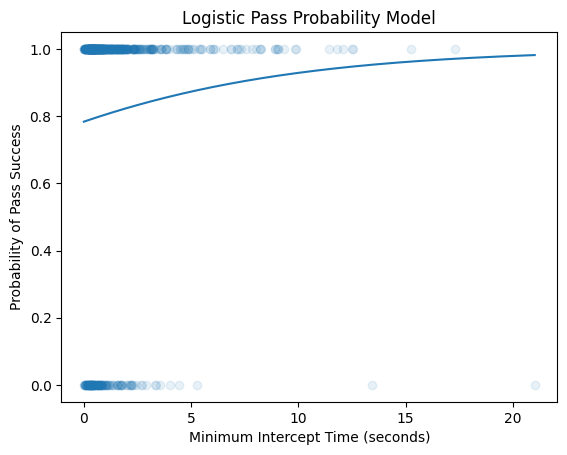

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Create smooth range of intercept times
t_vals = np.linspace(
    eda_pass_df3["min_intercept_time"].min(),
    eda_pass_df3["min_intercept_time"].max(),
    200
)

# Compute predicted probabilities
probs = model.predict_proba(t_vals.reshape(-1, 1))[:, 1]

plt.figure()
plt.scatter(
    eda_pass_df3["min_intercept_time"],
    eda_pass_df3["success"],
    alpha=0.1
)
plt.plot(t_vals, probs)
plt.xlabel("Minimum Intercept Time (seconds)")
plt.ylabel("Probability of Pass Success")
plt.title("Logistic Pass Probability Model")
plt.show()

In [45]:
match_ids = ["3812", "3813", "3814", "3815", "3816"]

In [46]:
import json, bz2, math
import numpy as np
import pandas as pd

def find_by_jersey(players_list, jersey_num):
    for p in players_list:
        if int(p.get("jerseyNum")) == int(jersey_num):
            return p
    return None

def point_to_segment_dist(ax, ay, bx, by, px, py):
    ABx, ABy = (bx-ax), (by-ay)
    APx, APy = (px-ax), (py-ay)
    ab2 = ABx*ABx + ABy*ABy
    if ab2 == 0:
        return math.dist((ax, ay), (px, py))
    t = (APx*ABx + APy*ABy) / ab2
    t = max(0, min(1, t))
    cx, cy = ax + t*ABx, ay + t*ABy
    return math.dist((cx, cy), (px, py))

def get_ball_xy(frame):
    balls = frame.get("balls", [])
    if not balls:
        return None
    b = balls[0]
    x, y = b.get("x"), b.get("y")
    if x is None or y is None:
        return None
    return (x, y)

def build_tracking_index(tracking_path, dt=0.1):
    frames_by_period, times_by_period, last_kept = {}, {}, {}
    with bz2.open(tracking_path, "rt") as f:
        for line in f:
            fr = json.loads(line)
            per = int(fr["period"])
            t = float(fr["periodGameClockTime"])

            if per not in frames_by_period:
                frames_by_period[per] = []
                times_by_period[per] = []
                last_kept[per] = -1e9

            # downsample to ~10fps (0.1s)
            if t - last_kept[per] >= dt:
                frames_by_period[per].append(fr)
                times_by_period[per].append(t)
                last_kept[per] = t

    for per in times_by_period:
        times_by_period[per] = np.array(times_by_period[per], dtype=float)

    return frames_by_period, times_by_period

def get_closest_frame(frames_by_period, times_by_period, period, t):
    times = times_by_period.get(period)
    fr_list = frames_by_period.get(period)
    if times is None or len(times) == 0:
        return None
    i = np.searchsorted(times, t)
    if i == 0:
        return fr_list[0]
    if i >= len(times):
        return fr_list[-1]
    before, after = i-1, i
    return fr_list[after] if abs(times[after]-t) < abs(times[before]-t) else fr_list[before]

def get_next_frame(frames_by_period, times_by_period, period, t):
    times = times_by_period.get(period)
    fr_list = frames_by_period.get(period)
    if times is None or len(times) == 0:
        return None
    i = np.searchsorted(times, t)
    if i >= len(fr_list)-1:
        return None
    return fr_list[i+1]

def process_match(match_id, EVENT_DIR, TRACKING_DIR, dt=0.1):
    event_path = EVENT_DIR / f"{match_id}.json"
    tracking_path = TRACKING_DIR / f"{match_id}.jsonl.bz2"

    # --- load events ---
    with open(event_path, "r") as f:
        raw = json.load(f)
    df = pd.json_normalize(raw)

    # passes only
    passes = df[df["possessionEvents.possessionEventType"] == "PA"].copy()
    if len(passes) == 0:
        return pd.DataFrame(columns=["min_intercept_time", "success", "match_id"])

    # playerId -> jersey mapping (from metadata in first container)
    raw_first = raw[0]
    id_to_jersey = {}
    for p in raw_first["homePlayers"]:
        id_to_jersey[int(p["playerId"])] = int(p["jerseyNum"])
    for p in raw_first["awayPlayers"]:
        id_to_jersey[int(p["playerId"])] = int(p["jerseyNum"])

    # --- tracking index (downsampled) ---
    frames_by_period, times_by_period = build_tracking_index(tracking_path, dt=dt)

    results = []
    for _, row in passes.iterrows():
        pass_clock = float(row["possessionEvents.gameClock"])
        pass_period = int(row["gameEvents.period"])

        fr0 = get_closest_frame(frames_by_period, times_by_period, pass_period, pass_clock)
        fr1 = get_next_frame(frames_by_period, times_by_period, pass_period, pass_clock)
        if fr0 is None or fr1 is None:
            continue

        passer_id = row["possessionEvents.passerPlayerId"]
        if pd.isna(passer_id):
            continue
        passer_id = int(passer_id)

        passer_jersey = id_to_jersey.get(passer_id)
        if passer_jersey is None:
            continue

        home0, away0 = fr0["homePlayers"], fr0["awayPlayers"]

        passer_track = find_by_jersey(home0, passer_jersey) or find_by_jersey(away0, passer_jersey)
        if passer_track is None:
            continue

        px, py = float(passer_track["x"]), float(passer_track["y"])

        ball1 = get_ball_xy(fr1)
        if ball1 is None:
            continue
        bx, by = ball1

        # ignore no-motion
        if math.dist((px, py), (bx, by)) < 0.5:
            continue

        passer_team = "home" if find_by_jersey(home0, passer_jersey) is not None else "away"
        defenders = away0 if passer_team == "home" else home0

        # compute min intercept time
        min_t = None
        for d in defenders:
            dx, dy = float(d["x"]), float(d["y"])
            speed = max(float(d.get("speed", 0.0)), 0.01)
            dist_to_line = point_to_segment_dist(px, py, bx, by, dx, dy)
            t_int = dist_to_line / speed
            min_t = t_int if (min_t is None or t_int < min_t) else min_t

        outcome = row["possessionEvents.passOutcomeType"]
        success = 1 if outcome == "C" else 0

        results.append({
            "min_intercept_time": min_t,
            "success": success,
            "match_id": match_id
        })

    return pd.DataFrame(results)

In [47]:
test_df = process_match("3812", EVENT_DIR, TRACKING_DIR, dt=0.1)
print(test_df.shape)
print(test_df["success"].value_counts())
test_df.head()

(756, 3)
success
1    613
0    143
Name: count, dtype: int64


,min_intercept_time,success,match_id
0,5.053905,1,3812
1,0.402355,1,3812
2,2.552554,1,3812
3,0.252004,1,3812
4,0.952222,1,3812


In [48]:
all_dfs = []

for mid in match_ids:
    print(f"Processing match {mid}...")
    df_mid = process_match(mid, EVENT_DIR, TRACKING_DIR, dt=0.1)
    print("  shape:", df_mid.shape)
    all_dfs.append(df_mid)

combined_df = pd.concat(all_dfs, ignore_index=True)

print("\nCombined dataset shape:", combined_df.shape)
print("\nSuccess counts:")
print(combined_df["success"].value_counts())
print("\nMatches included:")
print(combined_df["match_id"].value_counts())

Processing match 3812...
  shape: (756, 3)
Processing match 3813...
  shape: (854, 3)
Processing match 3814...
  shape: (876, 3)
Processing match 3815...
  shape: (886, 3)
Processing match 3816...
  shape: (753, 3)

Combined dataset shape: (4125, 3)

Success counts:
success
1    3411
0     714
Name: count, dtype: int64

Matches included:
match_id
3815    886
3814    876
3813    854
3812    756
3816    753
Name: count, dtype: int64


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

X = combined_df[["min_intercept_time"]].values
y = combined_df["success"].values

model_multi = LogisticRegression()
model_multi.fit(X, y)

y_pred_prob = model_multi.predict_proba(X)[:, 1]
y_pred = model_multi.predict(X)

acc = accuracy_score(y, y_pred)
ll = log_loss(y, y_pred_prob)

print("Coefficient (beta_1):", model_multi.coef_[0][0])
print("Intercept (beta_0):", model_multi.intercept_[0])
print("Accuracy:", acc)
print("Log-loss:", ll)

Coefficient (beta_1): 0.0009400601942894973
Intercept (beta_0): 1.252663380057927
Accuracy: 0.8269090909090909
Log-loss: 0.4528585411544426


In [50]:
print("Min:", combined_df["min_intercept_time"].min())
print("Max:", combined_df["min_intercept_time"].max())
print("Mean:", combined_df["min_intercept_time"].mean())
print("Std:", combined_df["min_intercept_time"].std())

Min: 0.00024120765491101714
Max: 4486.204704424443
Mean: 380.5447445374928
Std: 424.2691602675991


In [51]:
combined_df["min_intercept_time_capped"] = combined_df["min_intercept_time"].clip(upper=5)

print("New max:", combined_df["min_intercept_time_capped"].max())

New max: 5.0


In [52]:
X = combined_df[["min_intercept_time_capped"]].values
y = combined_df["success"].values

model_capped = LogisticRegression()
model_capped.fit(X, y)

y_pred_prob = model_capped.predict_proba(X)[:, 1]
y_pred = model_capped.predict(X)

acc = accuracy_score(y, y_pred)
ll = log_loss(y, y_pred_prob)

print("Coefficient:", model_capped.coef_[0][0])
print("Intercept:", model_capped.intercept_[0])
print("Accuracy:", acc)
print("Log-loss:", ll)

Coefficient: 0.057989638760226114
Intercept: 1.3167895594662715
Accuracy: 0.8269090909090909
Log-loss: 0.4601292071307365


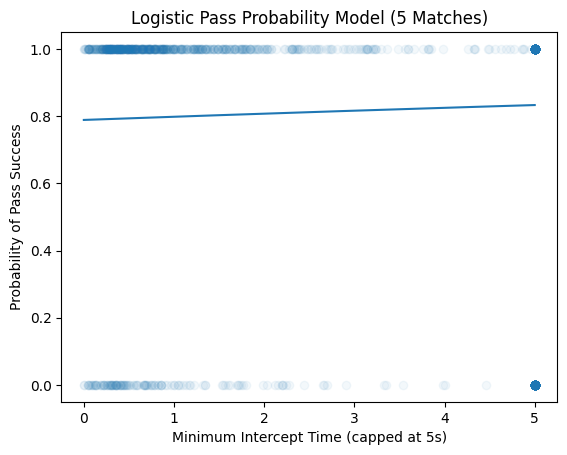

In [53]:
import numpy as np
import matplotlib.pyplot as plt

t_vals = np.linspace(0, 5, 200)
probs = model_capped.predict_proba(t_vals.reshape(-1, 1))[:, 1]

plt.figure()
plt.scatter(
    combined_df["min_intercept_time_capped"],
    combined_df["success"],
    alpha=0.05
)
plt.plot(t_vals, probs)
plt.xlabel("Minimum Intercept Time (capped at 5s)")
plt.ylabel("Probability of Pass Success")
plt.title("Logistic Pass Probability Model (5 Matches)")
plt.show()

# Pass Probability Modeling – Preliminary Physics-Based Implementation

## Objective

Develop a preliminary pass probability model inspired by physics-based interception logic (Spearman, SSAC 2017).

The goal is to move beyond purely geometric proximity and incorporate defender velocity to approximate interception risk.

---

## Dataset

Matches analyzed:
- 3812
- 3813
- 3814
- 3815
- 3816

Total passes analyzed: 4,125  
- Successful: 3,411  
- Failed: 714  

Tracking data was downsampled to ~10 FPS to reduce computational load while preserving spatial fidelity.

---

## Feature Engineering

### Intercept Time (Physics Proxy)

For each pass:

1. Identify pass start frame.
2. Approximate pass direction using ball movement in the next tracking frame.
3. For each defender, compute:

   intercept_time = distance_to_pass_line / defender_speed

4. Take the minimum intercept time across all defenders:

   min_intercept_time = minimum(intercept_time across defenders)

This represents the fastest defender’s estimated time to reach the ball path.

---

## Handling Extreme Values

Raw intercept times contained unrealistic outliers due to near-zero defender speeds.

To maintain physical realism:
- Intercept times were capped at 5 seconds.

This reflects practical defensive reach windows and prevents extreme values from distorting the model.

---

## Logistic Regression Model

We fit a logistic regression model:

Probability(pass_success) = sigmoid(beta_0 + beta_1 * min_intercept_time)

Results (5 matches combined):

- beta_1 = 0.058 (positive relationship)
- Log-loss = 0.460
- Accuracy = 0.827

---

## Interpretation

- Intercept time positively correlates with pass success probability.
- Larger defender intercept time → higher likelihood of pass completion.
- Effect size is moderate, suggesting intercept time alone is not sufficient.
- Additional physical components (ball arrival time, acceleration constraints, directional velocity) are likely needed to improve separation.

---

## Key Takeaways

- Pure geometric distance has predictive signal.
- Incorporating defender velocity improves probabilistic structure.
- Multi-match modeling stabilizes results.
- Current model serves as a rough but physics-aligned baseline for pass probability estimation.

---

## Next Steps

- Incorporate ball arrival time.
- Model delta_t = intercept_time − ball_travel_time.
- Add acceleration constraints.
- Explore multi-feature logistic model.
- Extend to pitch control integration.